## This code takes in George's annotated song vs. not-song annotations, then calculates the maximum periodicity value for contiguous song and not-song segments, then plots their distribution as a histogram

# For each file: find chunks of song vs. not-song:

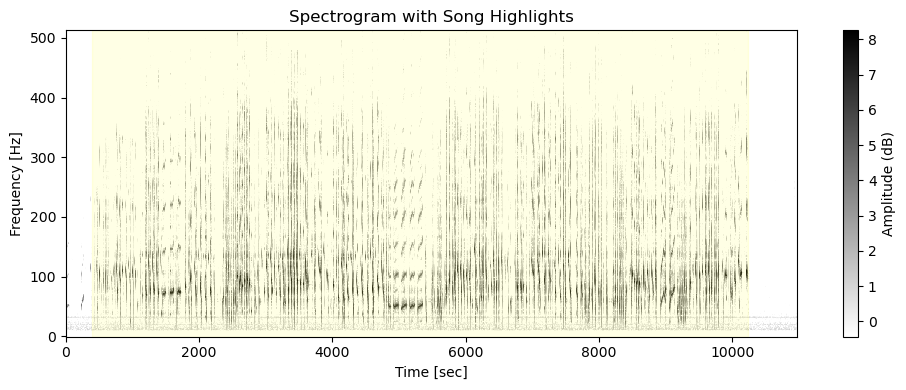

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram_with_song_highlight(npz_path: str):
    """
    Load a .npz file containing:
      - 's': spectrogram amplitude (shape: [n_freqs, n_times])
      - 'f': optional frequency bins
      - 't': optional time bins
      - 'songs': binary mask (0/1) for song presence per time bin
    and plot the spectrogram with yellow highlighted song segments,
    using the 'binary' colormap.
    """
    # Load data
    with np.load(npz_path, allow_pickle=True) as data:
        s = data['s']
        f = data['f'] if 'f' in data.files else np.arange(s.shape[0])
        t = data['t'] if 't' in data.files else np.arange(s.shape[1])
        songs = data['song'].astype(bool)

    # Detect contiguous song intervals
    padded = np.concatenate(([False], songs, [False]))
    diff = np.diff(padded.astype(int))
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]

    # Plot spectrogram with 'binary' colormap
    plt.figure(figsize=(10, 4))
    mesh = plt.pcolormesh(t, f, s, shading='auto', cmap='binary')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram with Song Highlights')
    cbar = plt.colorbar(mesh)
    cbar.set_label('Amplitude (dB)' if s.dtype.kind == 'f' else 'Power')

    # Overlay song segments
    for start, end in zip(starts, ends):
        plt.axvspan(t[start], t[end-1], color='yellow', alpha=0.1)

    plt.tight_layout()
    plt.show()

# Example usage:
npz_path = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/USA5203_45196.25388461_9_27_7_3_8_segment_0.npz"
plot_spectrogram_with_song_highlight(npz_path)

# Calculate the periodicity

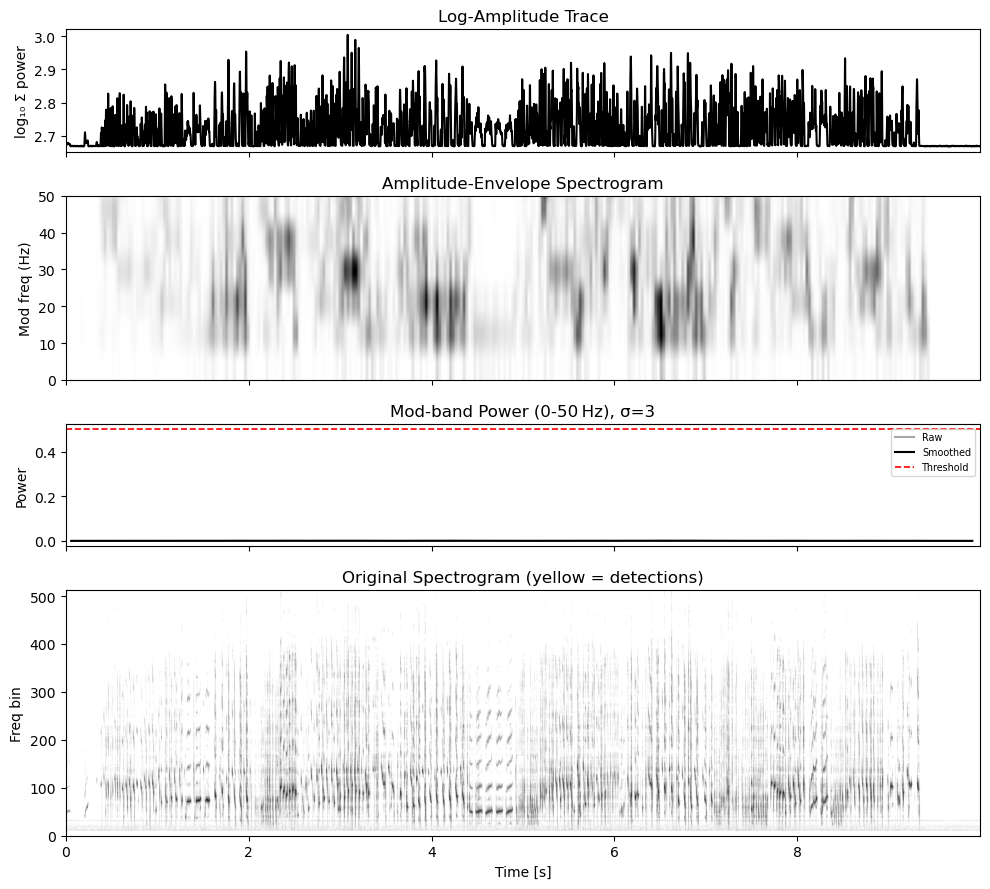

[8.35360147e-07 9.95540669e-08 7.54119206e-09 7.13815207e-09
 4.26301852e-06 1.53221381e-05 9.44401148e-06 3.87032318e-06
 3.90131557e-07 4.36049427e-07 3.21537839e-06 1.58531105e-05
 4.55523844e-05 1.26068681e-04 1.76158707e-04 1.05314906e-04
 1.08660099e-04 1.87379469e-04 2.10236978e-04 1.31695646e-04
 9.30708280e-05 8.01856411e-05 9.95779572e-05 1.13386101e-04
 9.42700690e-05 5.43717292e-05 5.59524451e-05 4.86426912e-05
 9.07737405e-05 1.12311771e-04 1.00831788e-04 1.02196312e-04
 9.96880964e-05 9.96064538e-05 1.16100283e-04 1.94756186e-04
 2.18689012e-04 1.72828427e-04 1.67279974e-04 9.42224447e-05
 1.11980674e-04 1.41871270e-04 1.45630180e-04 4.07440101e-05
 5.43109129e-05 1.07050397e-04 1.38152801e-04 7.30410240e-05
 8.24237690e-05 1.10276303e-04 4.25828111e-05 8.90223321e-05
 1.16325279e-04 2.77572553e-04 5.56906569e-04 2.24750429e-04
 1.98967106e-04 2.67393245e-04 3.39165920e-04 8.21205536e-04
 3.35866099e-04 3.85529475e-04 3.94262171e-04 6.61654676e-04
 5.28577180e-04 7.261882

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.ndimage import gaussian_filter1d

# ---------------------------------------------------------------------
# CONFIG – tweak these as desired
# ---------------------------------------------------------------------
FILE_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/USA5203_45196.25388461_9_27_7_3_8_segment_0.npz"

segment_duration = 10          # seconds the original pipeline used per segment
mod_low, mod_high = 0, 50      # modulation‑frequency band (Hz)
smoothing_sigma = 3            # σ for Gaussian smoothing of the power trace
power_threshold = 0.5          # detection threshold (arbitrary units)

# ---------------------------------------------------------------------
# Load the pre‑computed spectrogram
# ---------------------------------------------------------------------
with np.load(FILE_PATH, allow_pickle=True) as npz:
    S_db = npz["s"]          # pre‑computed spectrogram in dB (shape: [freq, time])

# We do not have explicit frequency/time vectors; reconstruct a *relative* axis.
n_freqs, n_times = S_db.shape
time_axis = np.linspace(0, segment_duration, n_times, endpoint=False)
freq_axis = np.arange(n_freqs)               # “bin index” – no absolute Hz available

# Convert dB → linear power, then build a log‑amplitude trace
S_lin   = 10 ** (S_db / 10)
eps     = np.finfo(float).eps
log_amp = np.log10(S_lin.sum(axis=0) + eps)

# ---------------------------------------------------------------------
# Envelope‑spectrogram of the amplitude trace
# ---------------------------------------------------------------------
amp_fs = len(time_axis) / segment_duration   # samples / second for the amplitude trace
nper   = 128
nover  = 96
f_env, t_env, S_env = spectrogram(
    log_amp,
    fs=amp_fs,
    window="hann",
    nperseg=nper,
    noverlap=nover,
)

# Modulation‑band raw & smoothed power
mod_mask   = (f_env >= mod_low) & (f_env <= mod_high)
raw_power  = S_env[mod_mask, :].sum(axis=0)
smooth_pow = gaussian_filter1d(raw_power, sigma=smoothing_sigma)

# ---------------------------------------------------------------------
# Plotting – stack four synced panels
# ---------------------------------------------------------------------
fig, axs = plt.subplots(
    4, 1, figsize=(10, 9), sharex=True,
    gridspec_kw=dict(height_ratios=[1, 1.5, 1, 2])
)

# 1) Log‑amplitude trace
axs[0].plot(time_axis, log_amp, color="black")
axs[0].set_ylabel("log₁₀ Σ power")
axs[0].set_title("Log‑Amplitude Trace")

# 2) Envelope‑spectrogram of the trace
im1 = axs[1].imshow(
    S_env,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], f_env[0], f_env[-1]],
    cmap="binary",
)
axs[1].set_ylim(0, mod_high)
axs[1].set_ylabel("Mod freq (Hz)")
axs[1].set_title("Amplitude‑Envelope Spectrogram")

# 3) Raw & smoothed modulation‑band power
axs[2].plot(t_env, raw_power,   color="grey",  alpha=0.7, label="Raw")
axs[2].plot(t_env, smooth_pow,  color="black",            label="Smoothed")
axs[2].axhline(power_threshold, color="red", ls="--", lw=1.2, label="Threshold")
axs[2].set_ylabel("Power")
axs[2].set_title(
    f"Mod‑band Power ({mod_low}-{mod_high} Hz), σ={smoothing_sigma}"
)

# Highlight detections
detect = smooth_pow > power_threshold
in_span = False
for idx, flag in enumerate(detect):
    if flag and not in_span:
        in_span, t_start = True, t_env[idx]
    elif not flag and in_span:
        for ax in (axs[2], axs[3]):
            ax.axvspan(t_start, t_env[idx], color="yellow", alpha=0.3)
        in_span = False
if in_span:
    for ax in (axs[2], axs[3]):
        ax.axvspan(t_start, time_axis[-1], color="yellow", alpha=0.3)

axs[2].legend(fontsize="x-small", loc="upper right")

# 4) Original spectrogram (normalised 0–1 just for display)
S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + eps)
im2 = axs[3].imshow(
    S_norm,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
    cmap="binary",
)
axs[3].set_ylabel("Freq bin")
axs[3].set_xlabel("Time [s]")
axs[3].set_title("Original Spectrogram (yellow = detections)")

plt.tight_layout()
plt.show()

print(raw_power)


In [35]:
print(f_env)
print(mod_mask.sum())  # Number of frequency bins actually in the band


[  0.          8.5734375  17.146875   25.7203125  34.29375    42.8671875
  51.440625   60.0140625  68.5875     77.1609375  85.734375   94.3078125
 102.88125   111.4546875 120.028125  128.6015625 137.175     145.7484375
 154.321875  162.8953125 171.46875   180.0421875 188.615625  197.1890625
 205.7625    214.3359375 222.909375  231.4828125 240.05625   248.6296875
 257.203125  265.7765625 274.35      282.9234375 291.496875  300.0703125
 308.64375   317.2171875 325.790625  334.3640625 342.9375    351.5109375
 360.084375  368.6578125 377.23125   385.8046875 394.378125  402.9515625
 411.525     420.0984375 428.671875  437.2453125 445.81875   454.3921875
 462.965625  471.5390625 480.1125    488.6859375 497.259375  505.8328125
 514.40625   522.9796875 531.553125  540.1265625 548.7      ]
6


In [36]:
print(S_env[mod_mask, :].max())


0.0004339527725878844


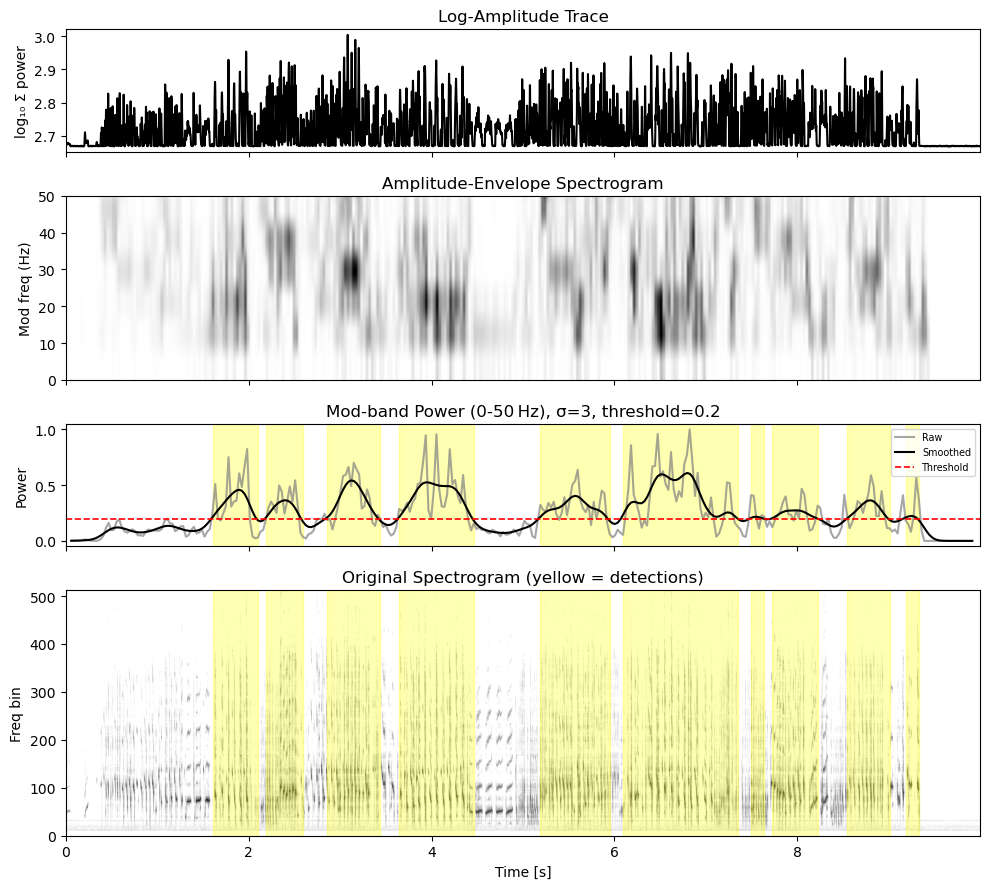

[7.64354888e-04 9.10920133e-05 6.90019393e-06 6.53141216e-06
 3.90066375e-03 1.40197628e-02 8.64127449e-03 3.54134734e-03
 3.56970539e-04 3.98985410e-04 2.94207258e-03 1.45056028e-02
 4.16804510e-02 1.15352897e-01 1.61185291e-01 9.63631833e-02
 9.94240361e-02 1.71452294e-01 1.92366924e-01 1.20501572e-01
 8.51598469e-02 7.33698955e-02 9.11138729e-02 1.03748331e-01
 8.62571530e-02 4.97501552e-02 5.11965109e-02 4.45080830e-02
 8.30580110e-02 1.02765317e-01 9.22611284e-02 9.35096689e-02
 9.12146503e-02 9.11399473e-02 1.06231808e-01 1.78201993e-01
 2.00100538e-01 1.58138083e-01 1.53061247e-01 8.62135767e-02
 1.02462364e-01 1.29812272e-01 1.33251677e-01 3.72807865e-02
 4.96945083e-02 9.79511584e-02 1.26409871e-01 6.68325678e-02
 7.54177835e-02 1.00902864e-01 3.89632901e-02 8.14554715e-02
 1.06437680e-01 2.53979004e-01 5.09569746e-01 2.05646737e-01
 1.82054986e-01 2.44664932e-01 3.10336960e-01 7.51403412e-01
 3.07317622e-01 3.52759633e-01 3.60750053e-01 6.05414308e-01
 4.83648343e-01 6.644625

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.ndimage import gaussian_filter1d

# ---------------------------------------------------------------------
# CONFIG – tweak these as desired
# ---------------------------------------------------------------------
FILE_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/USA5203_45196.25388461_9_27_7_3_8_segment_0.npz"

segment_duration = 10          # seconds the original pipeline used per segment
mod_low, mod_high = 0, 50      # modulation‑frequency band (Hz)
smoothing_sigma = 3            # σ for Gaussian smoothing of the power trace
power_threshold = 0.2          # detection threshold (arbitrary units)

# ---------------------------------------------------------------------
# Load the pre‑computed spectrogram
# ---------------------------------------------------------------------
with np.load(FILE_PATH, allow_pickle=True) as npz:
    S_db = npz["s"]          # pre‑computed spectrogram in dB (shape: [freq, time])

# We do not have explicit frequency/time vectors; reconstruct a *relative* axis.
n_freqs, n_times = S_db.shape
time_axis = np.linspace(0, segment_duration, n_times, endpoint=False)
freq_axis = np.arange(n_freqs)               # “bin index” – no absolute Hz available

# Convert dB → linear power, then build a log‑amplitude trace
S_lin   = 10 ** (S_db / 10)
eps     = np.finfo(float).eps
log_amp = np.log10(S_lin.sum(axis=0) + eps)

# ---------------------------------------------------------------------
# Envelope‑spectrogram of the amplitude trace
# ---------------------------------------------------------------------
amp_fs = len(time_axis) / segment_duration   # samples / second for the amplitude trace
nper   = 128
nover  = 96
f_env, t_env, S_env = spectrogram(
    log_amp,
    fs=amp_fs,
    window="hann",
    nperseg=nper,
    noverlap=nover,
)

# Modulation‑band raw & smoothed power
mod_mask   = (f_env >= mod_low) & (f_env <= mod_high)
raw_power = S_env[mod_mask, :].sum(axis=0)
raw_power /= raw_power.max() + 1e-12  # normalize for visibility
smooth_pow = gaussian_filter1d(raw_power, sigma=smoothing_sigma)

# ---------------------------------------------------------------------
# Plotting – stack four synced panels
# ---------------------------------------------------------------------
fig, axs = plt.subplots(
    4, 1, figsize=(10, 9), sharex=True,
    gridspec_kw=dict(height_ratios=[1, 1.5, 1, 2])
)

# 1) Log‑amplitude trace
axs[0].plot(time_axis, log_amp, color="black")
axs[0].set_ylabel("log₁₀ Σ power")
axs[0].set_title("Log‑Amplitude Trace")

# 2) Envelope‑spectrogram of the trace
im1 = axs[1].imshow(
    S_env,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], f_env[0], f_env[-1]],
    cmap="binary",
)
axs[1].set_ylim(0, mod_high)
axs[1].set_ylabel("Mod freq (Hz)")
axs[1].set_title("Amplitude‑Envelope Spectrogram")

# 3) Raw & smoothed modulation‑band power
axs[2].plot(t_env, raw_power,   color="grey",  alpha=0.7, label="Raw")
axs[2].plot(t_env, smooth_pow,  color="black",            label="Smoothed")
axs[2].axhline(power_threshold, color="red", ls="--", lw=1.2, label="Threshold")
axs[2].set_ylabel("Power")
axs[2].set_title(
    f"Mod‑band Power ({mod_low}-{mod_high} Hz), σ={smoothing_sigma}, threshold={power_threshold}"
)

# Highlight detections
detect = smooth_pow > power_threshold
in_span = False
for idx, flag in enumerate(detect):
    if flag and not in_span:
        in_span, t_start = True, t_env[idx]
    elif not flag and in_span:
        for ax in (axs[2], axs[3]):
            ax.axvspan(t_start, t_env[idx], color="yellow", alpha=0.3)
        in_span = False
if in_span:
    for ax in (axs[2], axs[3]):
        ax.axvspan(t_start, time_axis[-1], color="yellow", alpha=0.3)

axs[2].legend(fontsize="x-small", loc="upper right")

# 4) Original spectrogram (normalised 0–1 just for display)
S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + eps)
im2 = axs[3].imshow(
    S_norm,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
    cmap="binary",
)
axs[3].set_ylabel("Freq bin")
axs[3].set_xlabel("Time [s]")
axs[3].set_title("Original Spectrogram (yellow = detections)")

plt.tight_layout()
plt.show()

print(raw_power)


## Try fixing the spectrogram

In [38]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import spectrogram
# from scipy.ndimage import gaussian_filter1d

# # ---------------------------------------------------------------------
# # CONFIG – tweak these as desired
# # ---------------------------------------------------------------------
# FILE_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/USA5203_45196.25388461_9_27_7_3_8_segment_0.npz"

# segment_duration = 10          # seconds the original pipeline used per segment
# mod_low, mod_high = 0, 50      # modulation‑frequency band (Hz)
# smoothing_sigma = 3            # σ for Gaussian smoothing of the power trace
# power_threshold = 0.5          # detection threshold (arbitrary units)

# # ---------------------------------------------------------------------
# # Load the pre‑computed spectrogram
# # ---------------------------------------------------------------------
# with np.load(FILE_PATH, allow_pickle=True) as npz:
#     S_db = npz["s"]          # pre‑computed spectrogram in dB (shape: [freq, time])

# # We do not have explicit frequency/time vectors; reconstruct a *relative* axis.
# n_freqs, n_times = S_db.shape
# time_axis = np.linspace(0, segment_duration, n_times, endpoint=False)
# freq_axis = np.arange(n_freqs)               # “bin index” – no absolute Hz available

# # Convert dB → linear power, then build a log‑amplitude trace
# S_lin   = 10 ** (S_db / 10)
# eps     = np.finfo(float).eps
# log_amp = np.log10(S_lin.sum(axis=0) + eps)

# # ---------------------------------------------------------------------
# # Envelope‑spectrogram of the amplitude trace
# # ---------------------------------------------------------------------
# amp_fs = len(time_axis) / segment_duration   # samples / second for the amplitude trace
# nper = 512
# nover = 384

# f_env, t_env, S_env = spectrogram(
#     log_amp,
#     fs=amp_fs,
#     window="hann",
#     nperseg=nper,
#     noverlap=nover,
# )

# # Modulation‑band raw & smoothed power
# mod_mask   = (f_env >= mod_low) & (f_env <= mod_high)
# raw_power = S_env[mod_mask, :].sum(axis=0)
# raw_power /= raw_power.max() + 1e-12  # normalize for visibility
# smooth_pow = gaussian_filter1d(raw_power, sigma=smoothing_sigma)

# # ---------------------------------------------------------------------
# # Plotting – stack four synced panels
# # ---------------------------------------------------------------------
# fig, axs = plt.subplots(
#     4, 1, figsize=(10, 9), sharex=True,
#     gridspec_kw=dict(height_ratios=[1, 1.5, 1, 2])
# )

# # 1) Log‑amplitude trace
# axs[0].plot(time_axis, log_amp, color="black")
# axs[0].set_ylabel("log₁₀ Σ power")
# axs[0].set_title("Log‑Amplitude Trace")

# # 2) Envelope‑spectrogram of the trace
# im1 = axs[1].imshow(
#     S_env,
#     origin="lower",
#     aspect="auto",
#     extent=[time_axis[0], time_axis[-1], f_env[0], f_env[-1]],
#     cmap="binary",
# )
# axs[1].set_ylim(0, mod_high)
# axs[1].set_ylabel("Mod freq (Hz)")
# axs[1].set_title("Amplitude‑Envelope Spectrogram")

# # 3) Raw & smoothed modulation‑band power
# axs[2].plot(t_env, raw_power,   color="grey",  alpha=0.7, label="Raw")
# axs[2].plot(t_env, smooth_pow,  color="black",            label="Smoothed")
# axs[2].axhline(power_threshold, color="red", ls="--", lw=1.2, label="Threshold")
# axs[2].set_ylabel("Power")
# axs[2].set_title(
#     f"Mod‑band Power ({mod_low}-{mod_high} Hz), σ={smoothing_sigma}, threshold={power_threshold}"
# )

# # Highlight detections
# detect = smooth_pow > power_threshold
# in_span = False
# for idx, flag in enumerate(detect):
#     if flag and not in_span:
#         in_span, t_start = True, t_env[idx]
#     elif not flag and in_span:
#         for ax in (axs[2], axs[3]):
#             ax.axvspan(t_start, t_env[idx], color="yellow", alpha=0.3)
#         in_span = False
# if in_span:
#     for ax in (axs[2], axs[3]):
#         ax.axvspan(t_start, time_axis[-1], color="yellow", alpha=0.3)

# axs[2].legend(fontsize="x-small", loc="upper right")

# # 4) Original spectrogram (normalised 0–1 just for display)
# S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + eps)
# im2 = axs[3].imshow(
#     S_norm,
#     origin="lower",
#     aspect="auto",
#     extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
#     cmap="binary",
# )
# axs[3].set_ylabel("Freq bin")
# axs[3].set_xlabel("Time [s]")
# axs[3].set_title("Original Spectrogram (yellow = detections)")

# plt.tight_layout()
# plt.show()

# print(raw_power)


# Ok, back in business! Now, find the contiguous segments of song vs. not-song in each segment:

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_spectrogram_with_song_highlight(npz_path: str):
#     """
#     Load a .npz file and plot its spectrogram with song and non-song segments highlighted.
#     Also return the corresponding time segments as lists of tuples.
#     """
#     with np.load(npz_path, allow_pickle=True) as data:
#         s = data['s']
#         f = data['f'] if 'f' in data.files else np.arange(s.shape[0])
#         t = data['t'] if 't' in data.files else np.arange(s.shape[1])
#         songs = data['song'].astype(bool)

#     # Pad and detect song segment indices
#     padded = np.concatenate(([False], songs, [False]))
#     diff = np.diff(padded.astype(int))
#     song_starts = np.where(diff == 1)[0]
#     song_ends   = np.where(diff == -1)[0]

#     # Invert mask for not-song segments
#     not_songs = ~songs
#     padded_not = np.concatenate(([False], not_songs, [False]))
#     diff_not = np.diff(padded_not.astype(int))
#     nonsong_starts = np.where(diff_not == 1)[0]
#     nonsong_ends   = np.where(diff_not == -1)[0]

#     # Convert to time segments
#     song_segments = [(t[start], t[end - 1]) for start, end in zip(song_starts, song_ends)]
#     nonsong_segments = [(t[start], t[end - 1]) for start, end in zip(nonsong_starts, nonsong_ends)]

#     # # Plot
#     # plt.figure(figsize=(10, 4))
#     # mesh = plt.pcolormesh(t, f, s, shading='auto', cmap='binary')
#     # plt.ylabel('Frequency [Hz]')
#     # plt.xlabel('Time [sec]')
#     # plt.title('Spectrogram with Song and Non-Song Highlights')
#     # cbar = plt.colorbar(mesh)
#     # cbar.set_label('Amplitude (dB)' if s.dtype.kind == 'f' else 'Power')

#     # # Overlay yellow for song, light gray for nonsong
#     # for start, end in song_segments:
#     #     plt.axvspan(start, end, color='yellow', alpha=0.2)
#     # for start, end in nonsong_segments:
#     #     plt.axvspan(start, end, color='lightgray', alpha=0.1)

#     plt.tight_layout()
#     plt.show()

#     return song_segments, nonsong_segments


# # ===== Usage Example =====
# npz_path = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/USA5203_45196.25388461_9_27_7_3_8_segment_0.npz"  # Replace with actual path
# song_segs, nonsong_segs = plot_spectrogram_with_song_highlight(npz_path)

# # print("\n Song Segments:")
# # for s in song_segs:
# #     print(f"  {s[0]:.2f} s → {s[1]:.2f} s")

# # print("\nNon-Song Segments:")
# # for ns in nonsong_segs:
# #     print(f"  {ns[0]:.2f} s → {ns[1]:.2f} s")

# # ===== Usage =====
# npz_path = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/USA5203_45196.25388461_9_27_7_3_8_segment_0.npz"  # Replace with actual path
# starts, ends = plot_spectrogram_with_song_highlight(npz_path)
# #print("Starts:", starts)
# #print("Ends:", ends)

# not_song_indices = ends
# print(not_song_indices)
# song_indicies = starts
# print(song_indicies)

# print(raw_power)
# print(raw_power[390])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

[(0, 389), (10241, 10973)]
[(390, 10240)]
[7.64354888e-04 9.10920133e-05 6.90019393e-06 6.53141216e-06
 3.90066375e-03 1.40197628e-02 8.64127449e-03 3.54134734e-03
 3.56970539e-04 3.98985410e-04 2.94207258e-03 1.45056028e-02
 4.16804510e-02 1.15352897e-01 1.61185291e-01 9.63631833e-02
 9.94240361e-02 1.71452294e-01 1.92366924e-01 1.20501572e-01
 8.51598469e-02 7.33698955e-02 9.11138729e-02 1.03748331e-01
 8.62571530e-02 4.97501552e-02 5.11965109e-02 4.45080830e-02
 8.30580110e-02 1.02765317e-01 9.22611284e-02 9.35096689e-02
 9.12146503e-02 9.11399473e-02 1.06231808e-01 1.78201993e-01
 2.00100538e-01 1.58138083e-01 1.53061247e-01 8.62135767e-02
 1.02462364e-01 1.29812272e-01 1.33251677e-01 3.72807865e-02
 4.96945083e-02 9.79511584e-02 1.26409871e-01 6.68325678e-02
 7.54177835e-02 1.00902864e-01 3.89632901e-02 8.14554715e-02
 1.06437680e-01 2.53979004e-01 5.09569746e-01 2.05646737e-01
 1.82054986e-01 2.44664932e-01 3.10336960e-01 7.51403412e-01
 3.07317622e-01 3.52759633e-01 3.60750053e-

IndexError: index 390 is out of bounds for axis 0 with size 339


🎵 Contiguous SONG segments:
  0.38 s → 9.33 s

🔇 Contiguous NON-SONG segments:

🎵 Song periodicities (n = 308):
[0.0145056  0.04168045 0.1153529  0.16118529 0.09636318 0.09942404
 0.17145229 0.19236692 0.12050157 0.08515985 0.0733699  0.09111387
 0.10374833 0.08625715 0.04975016 0.05119651 0.04450808 0.08305801
 0.10276532 0.09226113 0.09350967 0.09121465 0.09113995 0.10623181
 0.17820199 0.20010054 0.15813808 0.15306125 0.08621358 0.10246236
 0.12981227 0.13325168 0.03728079 0.04969451 0.09795116 0.12640987
 0.06683257 0.07541778 0.10090286 0.03896329 0.08145547 0.10643768
 0.253979   0.50956975 0.20564674 0.18205499 0.24466493 0.31033696
 0.75140341 0.30731762 0.35275963 0.36075005 0.60541431 0.48364834
 0.66446255 0.82316374 0.18830385 0.0403603  0.02291491 0.02994004
 0.0833305  0.0980652  0.18939061 0.29837382 0.35277389 0.3077632
 0.25099497 0.4978341  0.43862822 0.24428495 0.35510377 0.4892706
 0.35199885 0.54337039 0.30792477 0.07171623 0.03323274 0.02174524
 0.06009513 0.0692

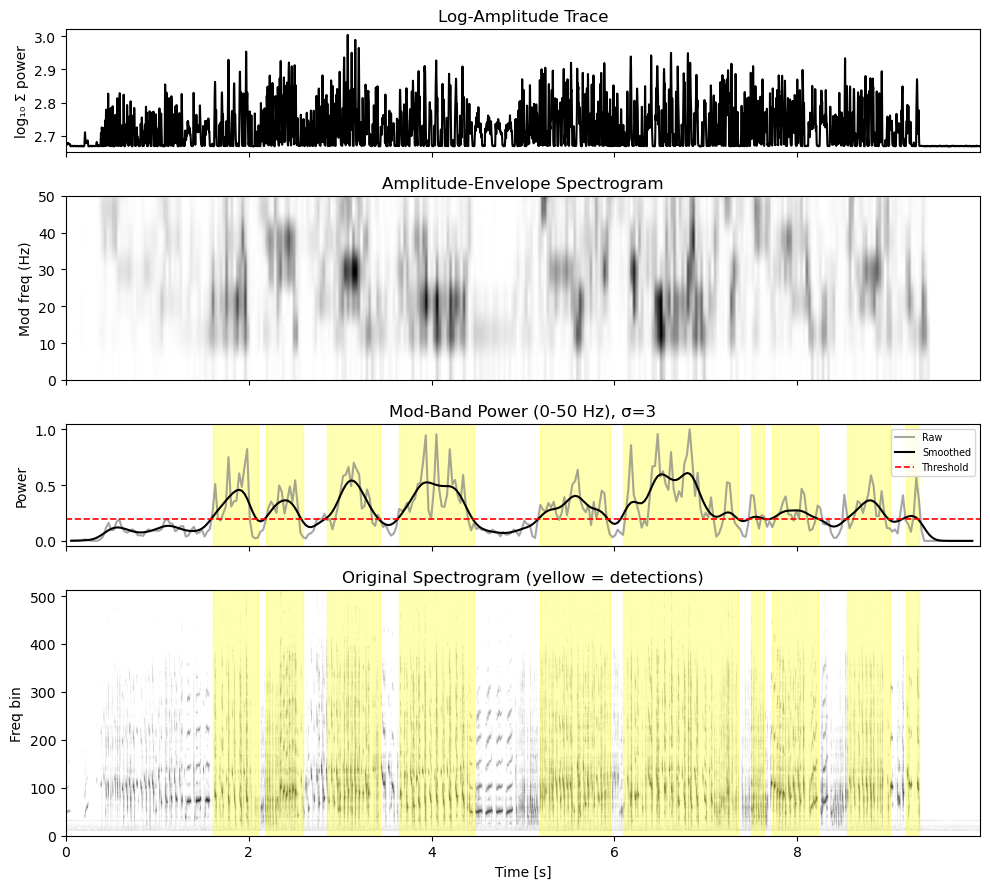

0.9999999999997968
0.09165693956768163
[(0.37907782030253323, 9.331146345908511)]
[]


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.ndimage import gaussian_filter1d

# ---------------------------------------------------------------------
# CONFIG – tweak these as desired
# ---------------------------------------------------------------------
FILE_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/USA5203_45196.25388461_9_27_7_3_8_segment_0.npz"

segment_duration = 10          # seconds the original pipeline used per segment
mod_low, mod_high = 0, 50      # modulation‑frequency band (Hz)
smoothing_sigma = 3            # σ for Gaussian smoothing of the power trace
power_threshold = 0.2          # detection threshold (arbitrary units)

# ---------------------------------------------------------------------
# Load spectrogram and song mask
# ---------------------------------------------------------------------
with np.load(FILE_PATH, allow_pickle=True) as npz:
    S_db = npz["s"]                 # spectrogram (freq × time)
    song_mask_full = npz["song"].astype(bool)  # high-res song mask

n_freqs, n_times = S_db.shape
time_axis = np.linspace(0, segment_duration, n_times, endpoint=False)
freq_axis = np.arange(n_freqs)

# dB → linear → log amplitude trace
S_lin = 10 ** (S_db / 10)
eps = np.finfo(float).eps
log_amp = np.log10(S_lin.sum(axis=0) + eps)

# ---------------------------------------------------------------------
# Envelope-spectrogram of log-amp trace
# ---------------------------------------------------------------------
amp_fs = len(time_axis) / segment_duration
nper = 128
nover = 96
f_env, t_env, S_env = spectrogram(
    log_amp,
    fs=amp_fs,
    window="hann",
    nperseg=nper,
    noverlap=nover,
)

mod_mask = (f_env >= mod_low) & (f_env <= mod_high)
raw_power = S_env[mod_mask, :].sum(axis=0)
raw_power /= raw_power.max() + eps
smooth_pow = gaussian_filter1d(raw_power, sigma=smoothing_sigma)

# ---------------------------------------------------------------------
# Align song mask to t_env
# ---------------------------------------------------------------------
nearest_indices = np.searchsorted(time_axis, t_env, side="right") - 1
nearest_indices = np.clip(nearest_indices, 0, len(song_mask_full) - 1)
song_mask_downsampled = song_mask_full[nearest_indices]


# Identify contiguous song and non-song segments
padded = np.concatenate(([False], song_mask_downsampled, [False]))
transitions = np.diff(padded.astype(int))
starts = np.where(transitions == 1)[0]
ends   = np.where(transitions == -1)[0]

# Separate song and nonsong segments based on original mask values
song_segments = []
nonsong_segments = []

for start_idx, end_idx in zip(starts, ends):
    segment = (t_env[start_idx], t_env[end_idx - 1])
    if padded[start_idx + 1]:  # this reflects the new (post-transition) state
        song_segments.append(segment)
    else:
        nonsong_segments.append(segment)

# Print segment summaries
print("\n🎵 Contiguous SONG segments:")
for seg in song_segments:
    print(f"  {seg[0]:.2f} s → {seg[1]:.2f} s")

print("\n🔇 Contiguous NON-SONG segments:")
for seg in nonsong_segments:
    print(f"  {seg[0]:.2f} s → {seg[1]:.2f} s")


song_periodicities = raw_power[song_mask_downsampled]
nonsong_periodicities = raw_power[~song_mask_downsampled]

# Print results
print(f"\n🎵 Song periodicities (n = {len(song_periodicities)}):")
print(song_periodicities)
print(f"\n🔇 Non-song periodicities (n = {len(nonsong_periodicities)}):")
print(nonsong_periodicities)

# ---------------------------------------------------------------------
# Plotting – 4 stacked panels
# ---------------------------------------------------------------------
fig, axs = plt.subplots(4, 1, figsize=(10, 9), sharex=True,
                        gridspec_kw=dict(height_ratios=[1, 1.5, 1, 2]))

# Panel 1: Log-amp
axs[0].plot(time_axis, log_amp, color="black")
axs[0].set_ylabel("log₁₀ Σ power")
axs[0].set_title("Log-Amplitude Trace")

# Panel 2: Envelope spectrogram
axs[1].imshow(
    S_env,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], f_env[0], f_env[-1]],
    cmap="binary",
)
axs[1].set_ylim(0, mod_high)
axs[1].set_ylabel("Mod freq (Hz)")
axs[1].set_title("Amplitude-Envelope Spectrogram")

# Panel 3: Mod-band power
axs[2].plot(t_env, raw_power, color="gray", alpha=0.7, label="Raw")
axs[2].plot(t_env, smooth_pow, color="black", label="Smoothed")
axs[2].axhline(power_threshold, color="red", ls="--", lw=1.2, label="Threshold")
axs[2].set_ylabel("Power")
axs[2].legend(fontsize="x-small", loc="upper right")
axs[2].set_title(f"Mod-Band Power ({mod_low}-{mod_high} Hz), σ={smoothing_sigma}")

# Panel 4: Original spectrogram with detections
S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + eps)
axs[3].imshow(
    S_norm,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
    cmap="binary",
)
axs[3].set_ylabel("Freq bin")
axs[3].set_xlabel("Time [s]")
axs[3].set_title("Original Spectrogram (yellow = detections)")

# Overlay yellow spans for detected segments
detect = smooth_pow > power_threshold
in_span = False
for idx, flag in enumerate(detect):
    if flag and not in_span:
        in_span, t_start = True, t_env[idx]
    elif not flag and in_span:
        for ax in (axs[2], axs[3]):
            ax.axvspan(t_start, t_env[idx], color="yellow", alpha=0.3)
        in_span = False
if in_span:
    for ax in (axs[2], axs[3]):
        ax.axvspan(t_start, time_axis[-1], color="yellow", alpha=0.3)

plt.tight_layout()
plt.show()


print(np.max(song_periodicities))
print(np.max(nonsong_periodicities))



#song_segments
print(song_segments)
#nonsong_segments
print(nonsong_segments)


In [56]:
print("First few values of song_mask_downsampled:", song_mask_downsampled[:10])
print("Last few values of song_mask_downsampled:", song_mask_downsampled[-10:])


First few values of song_mask_downsampled: [False False False False False False False False False False]
Last few values of song_mask_downsampled: [False False False False False False False False False False]



🎵 Max periodicity per SONG segment:

🔇 Max periodicity per NON-SONG segment:

🎵 Contiguous SONG segments:
  1.60 s → 2.07 s
  2.19 s → 2.57 s
  2.86 s → 3.41 s
  3.64 s → 4.43 s
  5.19 s → 5.92 s
  6.09 s → 7.32 s
  7.49 s → 7.61 s
  7.73 s → 8.19 s
  8.54 s → 8.98 s
  9.19 s → 9.30 s

🔇 Contiguous NON-SONG segments:

🎵 Song periodicities (n = 191):
[0.253979   0.50956975 0.20564674 0.18205499 0.24466493 0.31033696
 0.75140341 0.30731762 0.35275963 0.36075005 0.60541431 0.48364834
 0.66446255 0.82316374 0.18830385 0.0403603  0.02291491 0.18939061
 0.29837382 0.35277389 0.3077632  0.25099497 0.4978341  0.43862822
 0.24428495 0.35510377 0.4892706  0.35199885 0.54337039 0.30792477
 0.07171623 0.18682032 0.19590771 0.10311322 0.1956626  0.3027873
 0.44417647 0.58302949 0.59234159 0.6631974  0.48969221 0.70074884
 0.6424823  0.59737856 0.2896653  0.31109938 0.46127171 0.37899257
 0.16425648 0.13422906 0.23487521 0.28647595 0.26862329 0.28919342
 0.34361433 0.26104694 0.3436907  0.38172391 

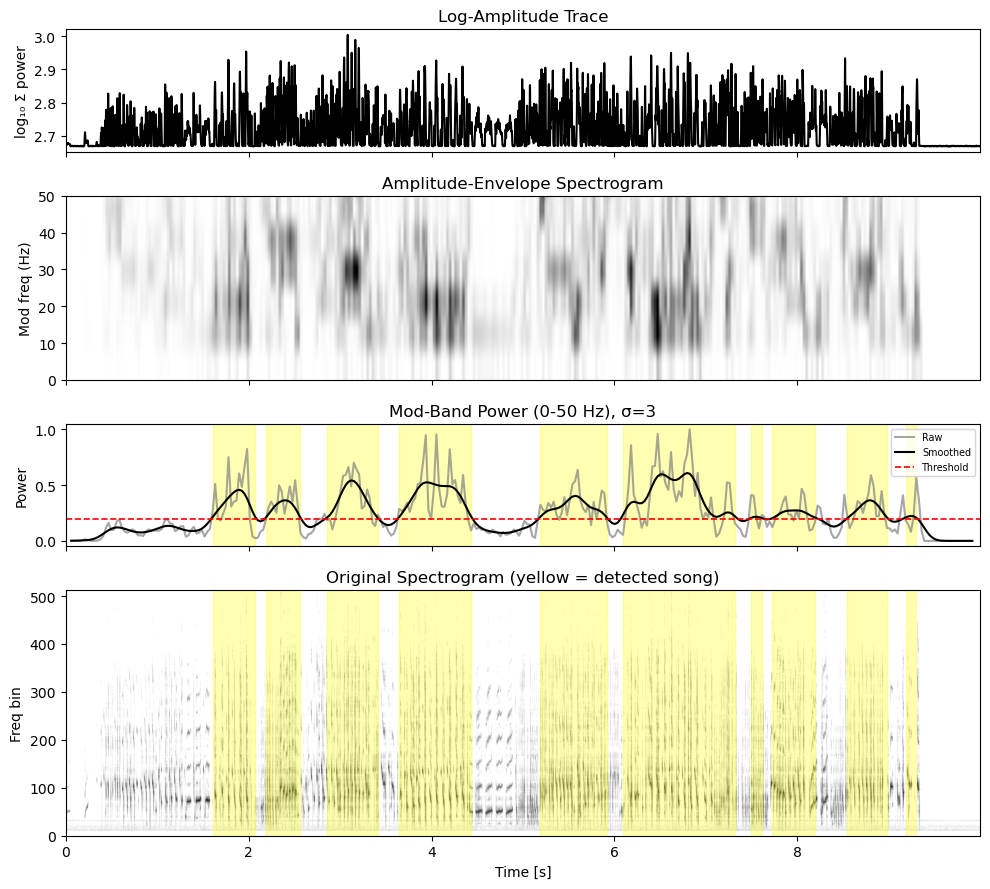


Max song periodicity: 1.0000
Max non-song periodicity: 0.4139


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.ndimage import gaussian_filter1d

# ---------------------------------------------------------------------
# CONFIG – tweak these as desired
# ---------------------------------------------------------------------
FILE_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/USA5203_45196.25388461_9_27_7_3_8_segment_0.npz"

segment_duration = 10          # seconds the original pipeline used per segment
mod_low, mod_high = 0, 50      # modulation‑frequency band (Hz)
smoothing_sigma = 3            # σ for Gaussian smoothing of the power trace
power_threshold = 0.2          # detection threshold (arbitrary units)

# ---------------------------------------------------------------------
# Load spectrogram
# ---------------------------------------------------------------------
with np.load(FILE_PATH, allow_pickle=True) as npz:
    S_db = npz["s"]  # spectrogram (freq × time)

n_freqs, n_times = S_db.shape
time_axis = np.linspace(0, segment_duration, n_times, endpoint=False)
freq_axis = np.arange(n_freqs)

# Convert dB to linear → log amplitude
S_lin = 10 ** (S_db / 10)
eps = np.finfo(float).eps
log_amp = np.log10(S_lin.sum(axis=0) + eps)

# ---------------------------------------------------------------------
# Envelope-spectrogram of log-amp trace
# ---------------------------------------------------------------------
amp_fs = len(time_axis) / segment_duration
nper = 128
nover = 96
f_env, t_env, S_env = spectrogram(
    log_amp,
    fs=amp_fs,
    window="hann",
    nperseg=nper,
    noverlap=nover,
)

# Mod-band power and detection mask
mod_mask = (f_env >= mod_low) & (f_env <= mod_high)
raw_power = S_env[mod_mask, :].sum(axis=0)
raw_power /= raw_power.max() + eps
smooth_pow = gaussian_filter1d(raw_power, sigma=smoothing_sigma)
detect = smooth_pow > power_threshold

# ---------------------------------------------------------------------
# Segment song vs. non-song from detection
# ---------------------------------------------------------------------
padded = np.concatenate(([False], detect, [False]))
transitions = np.diff(padded.astype(int))
starts = np.where(transitions == 1)[0]
ends   = np.where(transitions == -1)[0]

song_segments = []
nonsong_segments = []

# Helper to find the nearest index in t_env
def time_to_index(t0):
    return np.searchsorted(t_env, t0, side="left")

# Collect max periodicities per segment
max_song_per_segment = []
max_nonsong_per_segment = []

# Song segments
for start, end in song_segments:
    i0 = time_to_index(start)
    i1 = time_to_index(end)
    max_val = raw_power[i0:i1 + 1].max() if i1 >= i0 else 0
    max_song_per_segment.append((start, end, max_val))

# Nonsong segments
for start, end in nonsong_segments:
    i0 = time_to_index(start)
    i1 = time_to_index(end)
    max_val = raw_power[i0:i1 + 1].max() if i1 >= i0 else 0
    max_nonsong_per_segment.append((start, end, max_val))

# Print song segment results
print("\n🎵 Max periodicity per SONG segment:")
for start, end, max_val in max_song_per_segment:
    print(f"  {start:.2f}–{end:.2f} s → max periodicity = {max_val:.4f}")

# Print nonsong segment results
print("\n🔇 Max periodicity per NON-SONG segment:")
for start, end, max_val in max_nonsong_per_segment:
    print(f"  {start:.2f}–{end:.2f} s → max periodicity = {max_val:.4f}")


for start_idx, end_idx in zip(starts, ends):
    segment = (t_env[start_idx], t_env[end_idx - 1])
    if padded[start_idx + 1]:  # we transitioned into song
        song_segments.append(segment)
    else:
        nonsong_segments.append(segment)

# Print segment summaries
print("\n🎵 Contiguous SONG segments:")
for seg in song_segments:
    print(f"  {seg[0]:.2f} s → {seg[1]:.2f} s")

print("\n🔇 Contiguous NON-SONG segments:")
for seg in nonsong_segments:
    print(f"  {seg[0]:.2f} s → {seg[1]:.2f} s")

# ---------------------------------------------------------------------
# Extract periodicities for song vs. nonsong time bins
# ---------------------------------------------------------------------
song_periodicities = raw_power[detect]
nonsong_periodicities = raw_power[~detect]

print(f"\n🎵 Song periodicities (n = {len(song_periodicities)}):")
print(song_periodicities)
print(f"\n🔇 Non-song periodicities (n = {len(nonsong_periodicities)}):")
print(nonsong_periodicities)

# ---------------------------------------------------------------------
# Plotting – 4 stacked panels
# ---------------------------------------------------------------------
fig, axs = plt.subplots(4, 1, figsize=(10, 9), sharex=True,
                        gridspec_kw=dict(height_ratios=[1, 1.5, 1, 2]))

# Panel 1: Log amplitude
axs[0].plot(time_axis, log_amp, color="black")
axs[0].set_ylabel("log₁₀ Σ power")
axs[0].set_title("Log-Amplitude Trace")

# Panel 2: Envelope spectrogram
axs[1].imshow(
    S_env,
    origin="lower",
    aspect="auto",
    extent=[t_env[0], t_env[-1], f_env[0], f_env[-1]],
    cmap="binary",
)
axs[1].set_ylim(0, mod_high)
axs[1].set_ylabel("Mod freq (Hz)")
axs[1].set_title("Amplitude-Envelope Spectrogram")

# Panel 3: Power trace
axs[2].plot(t_env, raw_power, color="gray", alpha=0.7, label="Raw")
axs[2].plot(t_env, smooth_pow, color="black", label="Smoothed")
axs[2].axhline(power_threshold, color="red", ls="--", lw=1.2, label="Threshold")
axs[2].set_ylabel("Power")
axs[2].legend(fontsize="x-small", loc="upper right")
axs[2].set_title(f"Mod-Band Power ({mod_low}-{mod_high} Hz), σ={smoothing_sigma}")

# Panel 4: Original spectrogram with detections
S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + eps)
axs[3].imshow(
    S_norm,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
    cmap="binary",
)
axs[3].set_ylabel("Freq bin")
axs[3].set_xlabel("Time [s]")
axs[3].set_title("Original Spectrogram (yellow = detected song)")

# Overlay yellow spans for detected segments
for start, end in song_segments:
    for ax in (axs[2], axs[3]):
        ax.axvspan(start, end, color="yellow", alpha=0.3)

plt.tight_layout()
plt.show()

# Print max values for confirmation
print(f"\nMax song periodicity: {np.max(song_periodicities):.4f}")
print(f"Max non-song periodicity: {np.max(nonsong_periodicities):.4f}")



🎵 Max periodicity per SONG segment:

🔇 Max periodicity per NON-SONG segment:

🎵 Contiguous SONG segments:
  1.60 s → 2.07 s
  2.19 s → 2.57 s
  2.86 s → 3.41 s
  3.64 s → 4.43 s
  5.19 s → 5.92 s
  6.09 s → 7.32 s
  7.49 s → 7.61 s
  7.73 s → 8.19 s
  8.54 s → 8.98 s
  9.19 s → 9.30 s

🔇 Contiguous NON-SONG segments:

🎵 Song periodicities (n = 191):
[0.253979   0.50956975 0.20564674 0.18205499 0.24466493 0.31033696
 0.75140341 0.30731762 0.35275963 0.36075005 0.60541431 0.48364834
 0.66446255 0.82316374 0.18830385 0.0403603  0.02291491 0.18939061
 0.29837382 0.35277389 0.3077632  0.25099497 0.4978341  0.43862822
 0.24428495 0.35510377 0.4892706  0.35199885 0.54337039 0.30792477
 0.07171623 0.18682032 0.19590771 0.10311322 0.1956626  0.3027873
 0.44417647 0.58302949 0.59234159 0.6631974  0.48969221 0.70074884
 0.6424823  0.59737856 0.2896653  0.31109938 0.46127171 0.37899257
 0.16425648 0.13422906 0.23487521 0.28647595 0.26862329 0.28919342
 0.34361433 0.26104694 0.3436907  0.38172391 

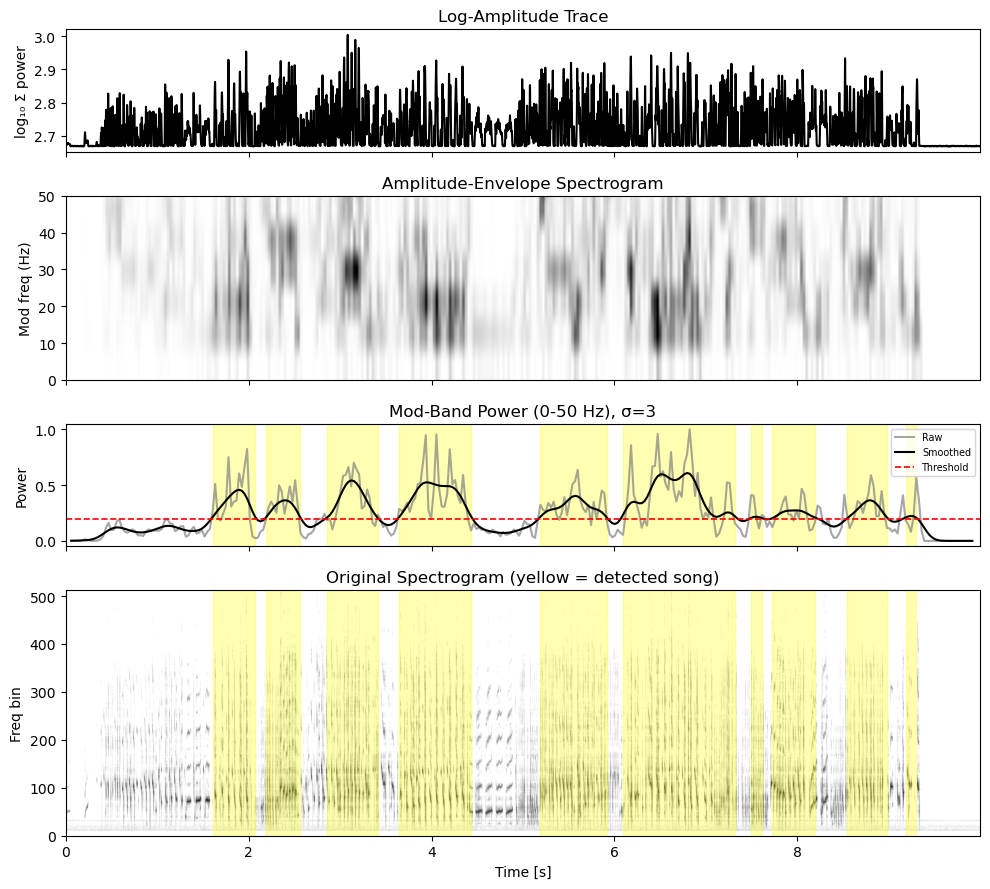


Max song periodicity: 1.0000
Max non-song periodicity: 0.4139


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.ndimage import gaussian_filter1d

# ---------------------------------------------------------------------
# CONFIG – tweak these as desired
# ---------------------------------------------------------------------
FILE_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/USA5203_45196.25388461_9_27_7_3_8_segment_0.npz"

segment_duration = 10          # seconds the original pipeline used per segment
mod_low, mod_high = 0, 50      # modulation‑frequency band (Hz)
smoothing_sigma = 3            # σ for Gaussian smoothing of the power trace
power_threshold = 0.2          # detection threshold (arbitrary units)

# ---------------------------------------------------------------------
# Load spectrogram
# ---------------------------------------------------------------------
with np.load(FILE_PATH, allow_pickle=True) as npz:
    S_db = npz["s"]  # spectrogram (freq × time)

n_freqs, n_times = S_db.shape
time_axis = np.linspace(0, segment_duration, n_times, endpoint=False)
freq_axis = np.arange(n_freqs)

# Convert dB to linear → log amplitude
S_lin = 10 ** (S_db / 10)
eps = np.finfo(float).eps
log_amp = np.log10(S_lin.sum(axis=0) + eps)

# ---------------------------------------------------------------------
# Envelope-spectrogram of log-amp trace
# ---------------------------------------------------------------------
amp_fs = len(time_axis) / segment_duration
nper = 128
nover = 96
f_env, t_env, S_env = spectrogram(
    log_amp,
    fs=amp_fs,
    window="hann",
    nperseg=nper,
    noverlap=nover,
)

# Mod-band power and detection mask
mod_mask = (f_env >= mod_low) & (f_env <= mod_high)
raw_power = S_env[mod_mask, :].sum(axis=0)
raw_power /= raw_power.max() + eps
smooth_pow = gaussian_filter1d(raw_power, sigma=smoothing_sigma)
detect = smooth_pow > power_threshold

# ---------------------------------------------------------------------
# Segment song vs. non-song from detection
# ---------------------------------------------------------------------
padded = np.concatenate(([False], detect, [False]))
transitions = np.diff(padded.astype(int))
starts = np.where(transitions == 1)[0]
ends   = np.where(transitions == -1)[0]

song_segments = []
nonsong_segments = []

# Helper to find the nearest index in t_env
def time_to_index(t0):
    return np.searchsorted(t_env, t0, side="left")

# Collect max periodicities per segment
max_song_per_segment = []
max_nonsong_per_segment = []

# Song segments
for start, end in song_segments:
    i0 = time_to_index(start)
    i1 = time_to_index(end)
    max_val = raw_power[i0:i1 + 1].max() if i1 >= i0 else 0
    max_song_per_segment.append((start, end, max_val))

# Nonsong segments
for start, end in nonsong_segments:
    i0 = time_to_index(start)
    i1 = time_to_index(end)
    max_val = raw_power[i0:i1 + 1].max() if i1 >= i0 else 0
    max_nonsong_per_segment.append((start, end, max_val))

# Print song segment results
print("\n🎵 Max periodicity per SONG segment:")
for start, end, max_val in max_song_per_segment:
    print(f"  {start:.2f}–{end:.2f} s → max periodicity = {max_val:.4f}")

# Print nonsong segment results
print("\n🔇 Max periodicity per NON-SONG segment:")
for start, end, max_val in max_nonsong_per_segment:
    print(f"  {start:.2f}–{end:.2f} s → max periodicity = {max_val:.4f}")


for start_idx, end_idx in zip(starts, ends):
    segment = (t_env[start_idx], t_env[end_idx - 1])
    if padded[start_idx + 1]:  # we transitioned into song
        song_segments.append(segment)
    else:
        nonsong_segments.append(segment)

# Print segment summaries
print("\n🎵 Contiguous SONG segments:")
for seg in song_segments:
    print(f"  {seg[0]:.2f} s → {seg[1]:.2f} s")

print("\n🔇 Contiguous NON-SONG segments:")
for seg in nonsong_segments:
    print(f"  {seg[0]:.2f} s → {seg[1]:.2f} s")

# ---------------------------------------------------------------------
# Extract periodicities for song vs. nonsong time bins
# ---------------------------------------------------------------------
song_periodicities = raw_power[detect]
nonsong_periodicities = raw_power[~detect]

print(f"\n🎵 Song periodicities (n = {len(song_periodicities)}):")
print(song_periodicities)
print(f"\n🔇 Non-song periodicities (n = {len(nonsong_periodicities)}):")
print(nonsong_periodicities)

# ---------------------------------------------------------------------
# Plotting – 4 stacked panels
# ---------------------------------------------------------------------
fig, axs = plt.subplots(4, 1, figsize=(10, 9), sharex=True,
                        gridspec_kw=dict(height_ratios=[1, 1.5, 1, 2]))

# Panel 1: Log amplitude
axs[0].plot(time_axis, log_amp, color="black")
axs[0].set_ylabel("log₁₀ Σ power")
axs[0].set_title("Log-Amplitude Trace")

# Panel 2: Envelope spectrogram
axs[1].imshow(
    S_env,
    origin="lower",
    aspect="auto",
    extent=[t_env[0], t_env[-1], f_env[0], f_env[-1]],
    cmap="binary",
)
axs[1].set_ylim(0, mod_high)
axs[1].set_ylabel("Mod freq (Hz)")
axs[1].set_title("Amplitude-Envelope Spectrogram")

# Panel 3: Power trace
axs[2].plot(t_env, raw_power, color="gray", alpha=0.7, label="Raw")
axs[2].plot(t_env, smooth_pow, color="black", label="Smoothed")
axs[2].axhline(power_threshold, color="red", ls="--", lw=1.2, label="Threshold")
axs[2].set_ylabel("Power")
axs[2].legend(fontsize="x-small", loc="upper right")
axs[2].set_title(f"Mod-Band Power ({mod_low}-{mod_high} Hz), σ={smoothing_sigma}")

# Panel 4: Original spectrogram with detections
S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + eps)
axs[3].imshow(
    S_norm,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
    cmap="binary",
)
axs[3].set_ylabel("Freq bin")
axs[3].set_xlabel("Time [s]")
axs[3].set_title("Original Spectrogram (yellow = detected song)")

# Overlay yellow spans for detected segments
for start, end in song_segments:
    for ax in (axs[2], axs[3]):
        ax.axvspan(start, end, color="yellow", alpha=0.3)

plt.tight_layout()
plt.show()

# Print max values for confirmation
print(f"\nMax song periodicity: {np.max(song_periodicities):.4f}")
print(f"Max non-song periodicity: {np.max(nonsong_periodicities):.4f}")



Downsampled song mask:
  Total frames: 76
  Song frames (True): 76
  Non-song frames (False): 0

🎵 Max periodicity per GROUND-TRUTH SONG segment:
  0.25–9.71 s → max = 2.9966

🔇 Max periodicity per GROUND-TRUTH NON-SONG segment:


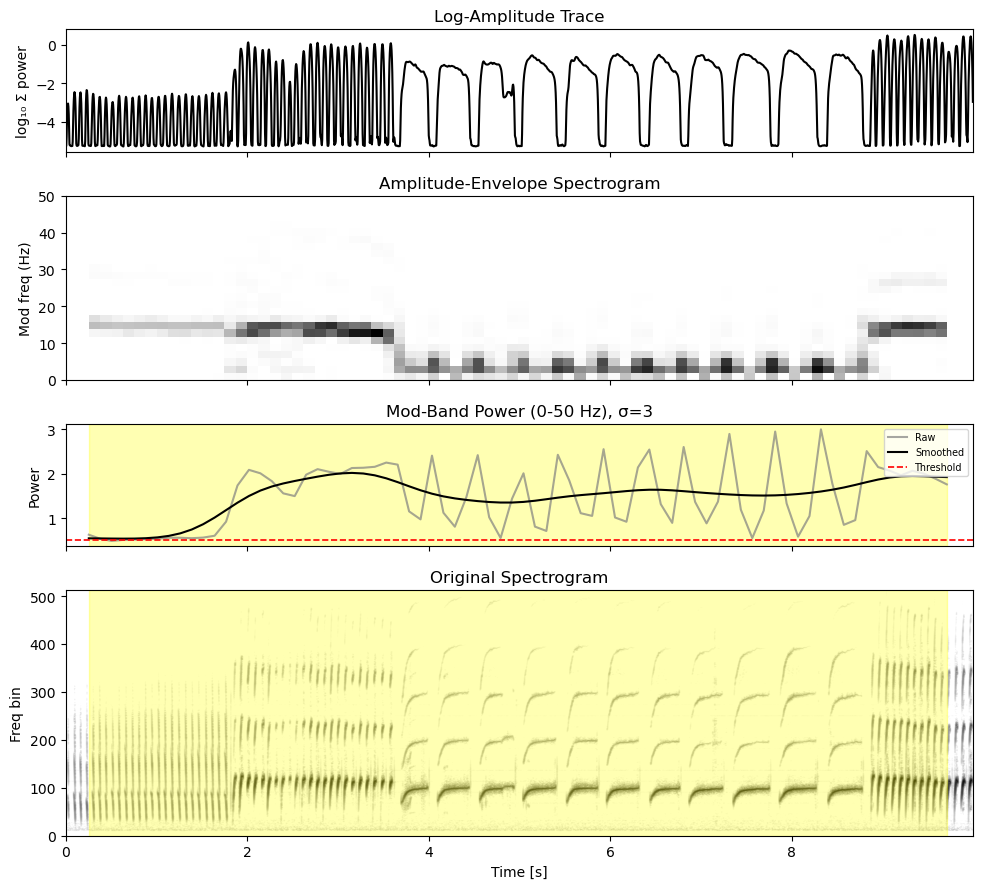


Raw periodicity power trace:
[0.6253411  0.53447041 0.48601986 0.50833625 0.51510415 0.52532582
 0.53365331 0.55788514 0.55663126 0.54689435 0.56044829 0.60216324
 0.91874584 1.73351936 2.08495573 2.00723595 1.83087312 1.55602204
 1.49445825 1.97637393 2.100482   2.04117849 1.99356712 2.12631471
 2.13237909 2.15358248 2.24855342 2.20221542 1.15002419 0.97040267
 2.40525936 1.11962777 0.80550129 1.46660182 2.41632863 1.01776386
 0.55169401 1.43681521 2.00712669 0.80729207 0.70965251 2.42397251
 1.84612592 1.10941603 1.04864853 2.54977495 1.01307025 0.91697764
 2.13776685 2.54188845 1.31259491 0.89153988 2.59994566 1.36395672
 0.88086274 1.37068018 2.89322964 1.18809912 0.54970525 1.1681627
 2.94655593 1.32915003 0.58132815 1.04542156 2.99662741 1.77190847
 0.84738372 0.95357477 2.50714941 2.14716357 2.06722308 1.9625308
 2.06402854 1.99921408 1.88690063 1.75772048]


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.ndimage import gaussian_filter1d

# ---------------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------------
FILE_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/llb3_0439_2018_04_25_05_59_56_segment_0.npz"
segment_duration = 10
mod_low, mod_high = 0, 50
smoothing_sigma = 3
power_threshold = 0.5

# ---------------------------------------------------------------------
# Load spectrogram and song mask
# ---------------------------------------------------------------------
with np.load(FILE_PATH, allow_pickle=True) as npz:
    S_db = npz["s"]
    song_mask_full = npz["song"].astype(bool)

n_freqs, n_times = S_db.shape
time_axis = np.linspace(0, segment_duration, n_times, endpoint=False)
freq_axis = np.arange(n_freqs)

# Convert dB → linear → log-amplitude trace
S_lin = 10 ** (S_db / 10)
eps = np.finfo(float).eps
log_amp = np.log10(S_lin.sum(axis=0) + eps)

# ---------------------------------------------------------------------
# Compute envelope spectrogram
# ---------------------------------------------------------------------
amp_fs = len(time_axis) / segment_duration
nper, nover = 128, 96
f_env, t_env, S_env = spectrogram(
    log_amp,
    fs=amp_fs,
    window="hann",
    nperseg=nper,
    noverlap=nover,
)

mod_mask = (f_env >= mod_low) & (f_env <= mod_high)
raw_power = S_env[mod_mask, :].sum(axis=0)
smooth_pow = gaussian_filter1d(raw_power, sigma=smoothing_sigma)

# ---------------------------------------------------------------------
# Downsample song mask to match t_env
# ---------------------------------------------------------------------
nearest_indices = np.searchsorted(time_axis, t_env, side="right") - 1
nearest_indices = np.clip(nearest_indices, 0, len(song_mask_full) - 1)
song_mask_downsampled = song_mask_full[nearest_indices]

print("Downsampled song mask:")
print("  Total frames:", len(song_mask_downsampled))
print("  Song frames (True):", np.sum(song_mask_downsampled))
print("  Non-song frames (False):", np.sum(~song_mask_downsampled))

# ---------------------------------------------------------------------
# Identify contiguous segments
# ---------------------------------------------------------------------
padded = np.concatenate(([False], song_mask_downsampled, [False]))
transitions = np.diff(padded.astype(int))
starts = np.where(transitions == 1)[0]
ends = np.where(transitions == -1)[0]

song_segments = []
nonsong_segments = []
max_song_per_segment = []
max_nonsong_per_segment = []

# Inferred non-song at start
if starts.size > 0 and starts[0] > 0:
    i0, i1 = 0, starts[0]
    nonsong_segments.append((t_env[i0], t_env[i1 - 1]))
    max_nonsong_per_segment.append((t_env[i0], t_env[i1 - 1], raw_power[i0:i1].max()))

# Add main song/non-song segments
for start_idx, end_idx in zip(starts, ends):
    t_start = t_env[start_idx]
    t_end = t_env[end_idx - 1]
    segment_power = raw_power[start_idx:end_idx]

    if padded[start_idx + 1]:
        song_segments.append((t_start, t_end))
        max_song_per_segment.append((t_start, t_end, segment_power.max()))
    else:
        nonsong_segments.append((t_start, t_end))
        max_nonsong_per_segment.append((t_start, t_end, segment_power.max()))

# Inferred non-song at end
if ends.size > 0 and ends[-1] < len(t_env) - 1:
    i0, i1 = ends[-1], len(t_env)
    nonsong_segments.append((t_env[i0], t_env[-1]))
    max_nonsong_per_segment.append((t_env[i0], t_env[-1], raw_power[i0:i1].max()))

# ---------------------------------------------------------------------
# Print results
# ---------------------------------------------------------------------
print("\n🎵 Max periodicity per GROUND-TRUTH SONG segment:")
for start, end, max_val in max_song_per_segment:
    print(f"  {start:.2f}–{end:.2f} s → max = {max_val:.4f}")

print("\n🔇 Max periodicity per GROUND-TRUTH NON-SONG segment:")
for start, end, max_val in max_nonsong_per_segment:
    print(f"  {start:.2f}–{end:.2f} s → max = {max_val:.4f}")

# ---------------------------------------------------------------------
# Plotting
# ---------------------------------------------------------------------
fig, axs = plt.subplots(4, 1, figsize=(10, 9), sharex=True,
                        gridspec_kw=dict(height_ratios=[1, 1.5, 1, 2]))

# Panel 1: Log amplitude trace
axs[0].plot(time_axis, log_amp, color="black")
axs[0].set_ylabel("log₁₀ Σ power")
axs[0].set_title("Log-Amplitude Trace")

# Panel 2: Envelope spectrogram
axs[1].imshow(
    S_env,
    origin="lower",
    aspect="auto",
    extent=[t_env[0], t_env[-1], f_env[0], f_env[-1]],
    cmap="binary",
)
axs[1].set_ylim(0, mod_high)
axs[1].set_ylabel("Mod freq (Hz)")
axs[1].set_title("Amplitude-Envelope Spectrogram")

# Panel 3: Mod-band power
axs[2].plot(t_env, raw_power, color="gray", alpha=0.7, label="Raw")
axs[2].plot(t_env, smooth_pow, color="black", label="Smoothed")
axs[2].axhline(power_threshold, color="red", ls="--", lw=1.2, label="Threshold")
axs[2].set_ylabel("Power")
axs[2].legend(fontsize="x-small", loc="upper right")
axs[2].set_title(f"Mod-Band Power ({mod_low}-{mod_high} Hz), σ={smoothing_sigma}")

# Panel 4: Original spectrogram
S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + eps)
axs[3].imshow(
    S_norm,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
    cmap="binary",
)
axs[3].set_ylabel("Freq bin")
axs[3].set_xlabel("Time [s]")
axs[3].set_title("Original Spectrogram")

# Overlay ground-truth song spans
for start, end in song_segments:
    for ax in (axs[2], axs[3]):
        ax.axvspan(start, end, color="yellow", alpha=0.3)

plt.tight_layout()
plt.show()

# Final output of raw trace (optional)
print("\nRaw periodicity power trace:")
print(raw_power)


## This works for ONE file^^

## Now, apply it to every .npz file in a folder, and output the values in a .json file

In [66]:
import numpy as np
from scipy.signal import spectrogram
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
import json

# ---------------------------------------------------------------------
# CONFIG — update this to your folder
# ---------------------------------------------------------------------
FOLDER_PATH = Path("/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/test")
segment_duration = 10
mod_low, mod_high = 0, 50
smoothing_sigma = 3

# ---------------------------------------------------------------------
# Function to process a single .npz file and return max values
# ---------------------------------------------------------------------
def process_npz_file(file_path):
    try:
        with np.load(file_path, allow_pickle=True) as npz:
            S_db = npz["s"]
            song_mask_full = npz["song"].astype(bool)
    except Exception as e:
        return {"file_name": file_path.name, "error": str(e)}

    n_freqs, n_times = S_db.shape
    time_axis = np.linspace(0, segment_duration, n_times, endpoint=False)
    eps = np.finfo(float).eps

    # Convert dB → log amplitude
    S_lin = 10 ** (S_db / 10)
    log_amp = np.log10(S_lin.sum(axis=0) + eps)

    # Envelope spectrogram
    amp_fs = len(time_axis) / segment_duration
    f_env, t_env, S_env = spectrogram(
        log_amp,
        fs=amp_fs,
        window="hann",
        nperseg=128,
        noverlap=96,
    )

    # Modulation band power
    mod_mask = (f_env >= mod_low) & (f_env <= mod_high)
    raw_power = S_env[mod_mask, :].sum(axis=0)
    smooth_pow = gaussian_filter1d(raw_power, sigma=smoothing_sigma)

    # Align ground-truth song mask
    nearest_indices = np.searchsorted(time_axis, t_env, side="right") - 1
    nearest_indices = np.clip(nearest_indices, 0, len(song_mask_full) - 1)
    song_mask_downsampled = song_mask_full[nearest_indices]

    # Segment detection
    padded = np.concatenate(([False], song_mask_downsampled, [False]))
    transitions = np.diff(padded.astype(int))
    starts = np.where(transitions == 1)[0]
    ends = np.where(transitions == -1)[0]

    max_song_vals = []
    max_nonsong_vals = []

    if starts.size > 0 and starts[0] > 0:
        i0, i1 = 0, starts[0]
        max_nonsong_vals.append(raw_power[i0:i1].max())

    for start_idx, end_idx in zip(starts, ends):
        segment_power = raw_power[start_idx:end_idx]
        if padded[start_idx + 1]:  # song segment
            max_song_vals.append(segment_power.max())
        else:  # non-song segment
            max_nonsong_vals.append(segment_power.max())

    if ends.size > 0 and ends[-1] < len(t_env) - 1:
        i0, i1 = ends[-1], len(t_env)
        max_nonsong_vals.append(raw_power[i0:i1].max())

    return {
        "file_name": file_path.name,
        "max_song_periodicity": float(np.max(max_song_vals)) if max_song_vals else None,
        "max_nonsong_periodicity": float(np.max(max_nonsong_vals)) if max_nonsong_vals else None
    }

# ---------------------------------------------------------------------
# Process all files and save output
# ---------------------------------------------------------------------
results = []
for npz_file in sorted(FOLDER_PATH.glob("*.npz")):
    result = process_npz_file(npz_file)
    results.append(result)

# Save JSON
output_json_path = FOLDER_PATH / "max_periodicity_summary.json"
with open(output_json_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved summary to: {output_json_path}")


Saved summary to: /Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/test/max_periodicity_summary.json


## Now, graph the output

In [1]:
import json
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------
# CONFIG — path to your summary .json file
# ---------------------------------------------------------------------
json_path = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/max_periodicity_summary.json")

# ---------------------------------------------------------------------
# Load data
# ---------------------------------------------------------------------
with open(json_path, "r") as f:
    data = json.load(f)

# Separate song and non-song periodicities
song_vals = []
nonsong_vals = []

for entry in data:
    if entry.get("max_song_periodicity") is not None:
        song_vals.append(entry["max_song_periodicity"])
    if entry.get("max_nonsong_periodicity") is not None:
        nonsong_vals.append(entry["max_nonsong_periodicity"])

# ---------------------------------------------------------------------
# Plot histogram
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 5))
bins = np.linspace(0, max(song_vals + nonsong_vals), 30)

plt.hist(nonsong_vals, bins=bins, color="black", alpha=0.7, label="Non-Song")
plt.hist(song_vals,     bins=bins, color="orange", alpha=0.7, label="Song")

plt.xlabel("Max Modulation-Band Periodicity")
plt.ylabel("Number of Recordings")
plt.title("Histogram of Max Periodicity Values\n(Song vs. Non-Song)")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'np' is not defined

<Figure size 800x500 with 0 Axes>